# **Vocal Biomarker Estimator for Parkinson’s Disease**

 **Notebook 2/2 - AI-Based Progression of Severity of Diagnosed Parkinson's Disease from Speech**
### AAI-590 Capstone Project

**Author:** Arifa Kokab  
**Group:** 11 (Solo)  
**Program:** M.Sc. Applied Artificial Intelligence  
**School:** University of San Diego - Shiley-Marcos School of Engineering  

#**INTRODUCTION**

This notebook is the second part of the Vocal Biomarker Estimator for Parkinson’s Disease project for the AAI-590 Capstone at the University of San Diego.

Whereas Notebook 1 tackled binary screening (healthy vs. Parkinson’s), this notebook estimates progression severity for patients already diagnosed. Severity is measured with the motor component of the Unified Parkinson’s Disease Rating Scale (motor_UPDRS), a clinician-rated score of motor function and daily living impact. We build a visit-level model from voice: the Oxford Parkinson’s Telemonitoring records are aggregated to one row per subject per day (averaging multiple phonations). Rather than predict the absolute score directly, the model predicts the change between consecutive visits (ΔUPDRS) from a short history of normalized voice features; the next absolute score is then reconstructed by adding the predicted change to the last known score. This framing centers progression, avoids inflated accuracy from repeated phonations within the same visit-day, and maps naturally to home monitoring.

Methodologically, the system uses a compact hybrid neural network—a bidirectional GRU branch for temporal trends and a 1D-CNN branch for local patterns. Inputs include the original acoustic features plus first-order deltas and three-visit rolling means, all z-scored within subject to remove personal baselines. Hyperparameters (sequence length, L2) are chosen via grouped cross-validation that holds out entire subjects; final performance is reported on a held-out subject set and compared against a naïve last-value and a Ridge baseline.

This is a research tool to support remote monitoring and clinical studies. It is not a diagnostic device and should be periodically re-anchored to clinician ratings to maintain calibration.

__

About the dataset:


**The Oxford Parkinson's Disease Telemonitoring Dataset**

The Oxford Parkinson’s Disease Telemonitoring Dataset, offering voice features and physician-rated Unified Parkinson’s Disease Rating Scale (UPDRS) scores for tracking disease severity.

*Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009).
"Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests."
IEEE Transactions on Biomedical Engineering*

Retrieved from: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

# Environment, Imports and Reproducibility Setup

This section sets up all dependencies and a reproducible runtime. NumPy and Pandas handle array and table operations; Matplotlib/Seaborn drive visualizations; scikit-learn provides mutual information, a Ridge baseline, subject-grouped cross-validation, and evaluation metrics. TensorFlow/Keras is used for the hybrid GRU–CNN model with regularization and training callbacks, and mixed precision is enabled for efficient GPU execution. SciPy supplies nonparametric significance tests. Global seeds and display settings are fixed for consistent results and clear plots.

In [46]:
# Environment & Imports
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold
from scipy.stats import wilcoxon, binomtest
import time

# Reproducibility
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
pd.set_option("display.max_columns", 200)
plt.rcParams["figure.dpi"] = 120

# Data Access and Mounting

This section mounts Google Drive to provide secure and persistent access to the dataset. Explicit directory paths are defined to locate the project’s data files.

In [2]:
# Data Access (Colab Drive)
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/Datasets for Capstone Project'
p3_path   = os.path.join(base_path, 'parkinsons3', 'parkinsons_updrs.data')

Mounted at /content/drive


# Data Loading and Initial Inspection

The dataset is loaded into memory using Pandas for structured data handling. The motor_UPDRS column, which serves as the target, and the test_time column, which serves as the temporal index, are explicitly cast to numeric types to prevent type inconsistencies. A random sample of rows is displayed alongside descriptive statistics for the relevant feature set to verify schema integrity and inspect variable ranges, central tendencies, and dispersion. This step confirms that the data conforms to expected structure before more complex preprocessing is undertaken.

In [3]:
#  Load & Prepare Visit-Level Data
df = pd.read_csv(p3_path)

voice_features = [
    'Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP',
    'Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA',
    'NHR','HNR','RPDE','DFA','PPE'
]
target     = 'motor_UPDRS'
subject_id = 'subject#'
time_var   = 'test_time'
time_var_day = 'visit_day'   # integer day index

# Basic type coercion
df[target]   = pd.to_numeric(df[target],   errors='coerce').astype('float32')
df[time_var] = pd.to_numeric(df[time_var], errors='coerce').astype('float32')

#**EXPLORATORY DATA ANALYSIS**

## EDA 1 — Schema, Row-Level Distributions, and Visit Duplicates

This first pass checks that the dataset loads correctly, the columns match expectations, and values sit in sensible ranges. A random sample gives a quick reality check across subjects, times, and features. The row-level histogram of motor_UPDRS shows a broad but centered spread, which suggests enough variability to learn from without extreme skew. Counting rows per subject×day reveals that each clinical visit often contains multiple phonation records. This matters because raw rows are not independent visits; the modeling pipeline therefore aggregates to one row per subject per day to avoid overweighting visits with many repeated recordings.

Shape: (5875, 22)


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
5366,39,66,0,138.399994,33.084000,43.563,0.00989,0.000070,0.00620,0.00419,0.01860,0.04139,0.329,0.02494,0.02016,0.02679,0.07481,0.049333,23.543,0.49315,0.64472,0.14389
4326,32,36,1,143.779999,7.159900,12.060,0.00427,0.000024,0.00199,0.00263,0.00596,0.02108,0.208,0.00935,0.01128,0.01660,0.02806,0.013491,23.979,0.53244,0.63642,0.23252
199,2,58,0,10.815000,11.218000,14.109,0.00970,0.000066,0.00510,0.00490,0.01530,0.05133,0.568,0.02949,0.03156,0.03813,0.08846,0.039924,18.384,0.49252,0.75548,0.23707
3260,24,60,0,39.827999,12.759000,16.517,0.00924,0.000071,0.00335,0.00402,0.01004,0.07344,0.672,0.03767,0.04703,0.04819,0.11301,0.081412,14.349,0.78034,0.78442,0.34791
4955,36,62,1,103.309998,25.391001,32.000,0.03199,0.000183,0.01681,0.02091,0.05043,0.12491,1.221,0.06463,0.07247,0.07086,0.19388,0.471650,6.092,0.71957,0.58285,0.46459


,count,mean,std,min,25%,50%,75%,max
Jitter(%),5875.0,0.006154,0.005624,0.000830,0.003580,0.004900,0.006800,0.099990
Jitter(Abs),5875.0,0.000044,0.000036,0.000002,0.000022,0.000035,0.000053,0.000446
Jitter:RAP,5875.0,0.002987,0.003124,0.000330,0.001580,0.002250,0.003290,0.057540
Jitter:PPQ5,5875.0,0.003277,0.003732,0.000430,0.001820,0.002490,0.003460,0.069560
Jitter:DDP,5875.0,0.008962,0.009371,0.000980,0.004730,0.006750,0.009870,0.172630
Shimmer,5875.0,0.034035,0.025835,0.003060,0.019120,0.027510,0.039750,0.268630
Shimmer(dB),5875.0,0.310960,0.230254,0.026000,0.175000,0.253000,0.365000,2.107000
Shimmer:APQ3,5875.0,0.017156,0.013237,0.001610,0.009280,0.013700,0.020575,0.162670
Shimmer:APQ5,5875.0,0.020144,0.016664,0.001940,0.010790,0.015940,0.023755,0.167020
Shimmer:APQ11,5875.0,0.027481,0.019986,0.002490,0.015665,0.022710,0.032715,0.275460


Missing values per column:
 Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
motor_UPDRS      0
dtype: int64


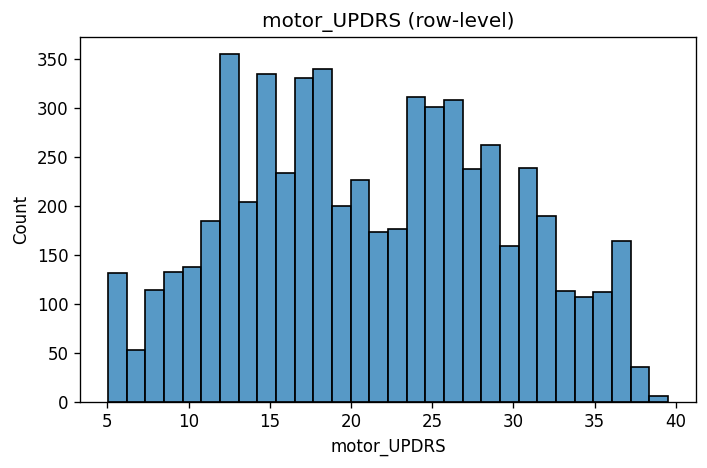

count    990.000000
mean       5.934343
std        0.495411
min        3.000000
25%        6.000000
50%        6.000000
75%        6.000000
max       12.000000
dtype: float64
6     909
5      68
4       7
12      3
3       2
Name: count, dtype: int64


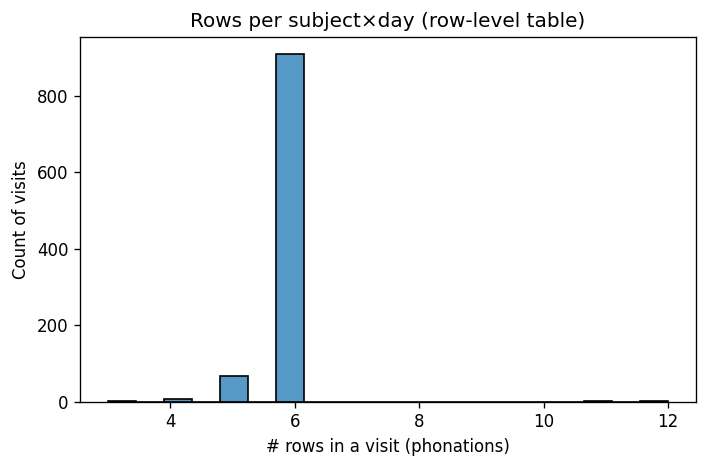

In [4]:
# EDA 1 — Schema, basic distributions, duplicates per visit
# Dataframe shape
print("Shape:", df.shape)
display(df.sample(5))
display(df[voice_features + [target, subject_id, time_var]].describe().T)

# Missing Values
na_counts = df[voice_features + [target]].isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", na_counts)

# Target distribution at row level (pre-aggregation)
plt.figure(figsize=(6,4))
sns.histplot(df['motor_UPDRS'], bins=30, edgecolor='k')
plt.title("motor_UPDRS (row-level)")
plt.xlabel("motor_UPDRS"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# How many rows per subject × day?  (reveals repeated phonations per visit)
raw_visit = df.copy()
raw_visit['visit_day'] = np.floor(raw_visit[time_var]).astype(int)
dup_counts = raw_visit.groupby([subject_id, 'visit_day']).size()

print(dup_counts.describe())
print(dup_counts.value_counts().head())

plt.figure(figsize=(6,4))
sns.histplot(dup_counts, bins=20, edgecolor='k')
plt.title("Rows per subject×day (row-level table)")
plt.xlabel("# rows in a visit (phonations)"); plt.ylabel("Count of visits")
plt.tight_layout(); plt.show()

## EDA 2 — Visit-Level Table and Coverage

The row-level table is collapsed to a visit-level table by averaging voice features and the target within each subject×day. This produces the structure the model will actually learn from: one observation per visit in chronological order. The resulting shape, number of unique subjects, and distribution of visit counts per subject confirm healthy coverage across patients. The histogram of visits per subject typically clusters around a modest number of visits, which motivates using short sequence windows so that most patients contribute to training and evaluation.

Visit-level shape: (990, 20)
Subjects: 42
Mean visits per subject: 23.571428571428573


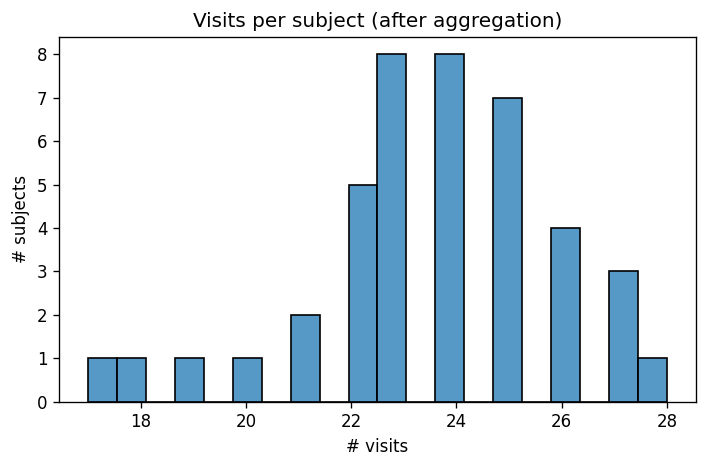

In [5]:
# EDA 2 — Build visit-level table and inspect coverage
voice_cols = voice_features[:]  # keep a clean alias

base_cols = voice_cols + [target, subject_id, time_var]
raw = df[base_cols].copy()
raw['visit_day'] = np.floor(raw[time_var]).astype(int)

agg_dict = {c: 'mean' for c in voice_cols}
agg_dict.update({target: 'mean', time_var: 'mean'})
dfv_eda = (raw
           .groupby([subject_id, 'visit_day'], as_index=False)
           .agg(agg_dict)
           .sort_values([subject_id, 'visit_day'])
           .reset_index(drop=True))

print("Visit-level shape:", dfv_eda.shape)
print("Subjects:", dfv_eda[subject_id].nunique())
print("Mean visits per subject:", dfv_eda.groupby(subject_id).size().mean())

plt.figure(figsize=(6,4))
sns.histplot(dfv_eda.groupby(subject_id).size(), bins=20, edgecolor='k')
plt.title("Visits per subject (after aggregation)")
plt.xlabel("# visits"); plt.ylabel("# subjects")
plt.tight_layout(); plt.show()

## EDA 3 — Time Gaps Between Visits

The gaps in days between consecutive visits are computed within each subject to understand the cadence of follow-ups. The distribution shows that many visits are spaced fairly closely, with occasional longer intervals. Irregular spacing is common in real clinics and reinforces our choice to index time by visit order rather than calendar time. Short gaps also explain why next-visit changes are often small, which in turn makes a persistence baseline strong and sets a realistic ceiling for near-term forecasting.

count    948.000000
mean       7.641350
std        2.785552
min        1.000000
25%        7.000000
50%        7.000000
75%        7.000000
max       32.000000
dtype: float64


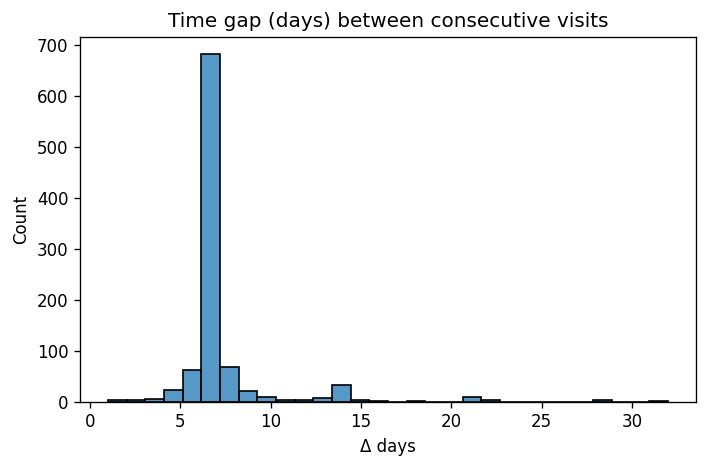

In [6]:
# EDA 3 — Time gaps between visits
gaps = []
for pid, g in dfv_eda.groupby(subject_id):
    g = g.sort_values('visit_day')
    d = np.diff(g['visit_day'].values)
    if len(d): gaps.extend(d)

gaps = np.array(gaps)
print(pd.Series(gaps).describe())

plt.figure(figsize=(6,4))
sns.histplot(gaps, bins=30, edgecolor='k')
plt.title("Time gap (days) between consecutive visits")
plt.xlabel("Δ days"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

## EDA 4 — Per-Subject Baseline and Variability

For each subject, the mean and standard deviation of motor_UPDRS are summarized at the visit level. Subject means form a smooth distribution, indicating diverse but reasonable baseline severities. Subject standard deviations are generally modest, which signals that most patients do not swing wildly between visits. A simple variance decomposition for selected features compares overall variance with between-subject variance and shows that a meaningful share of the spread is due to stable differences across people. This pattern justifies per-subject normalization so the model focuses on within-person dynamics instead of cross-person baselines.

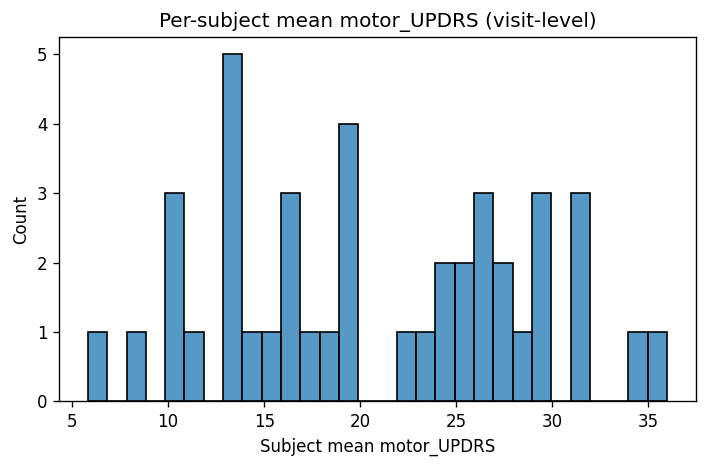

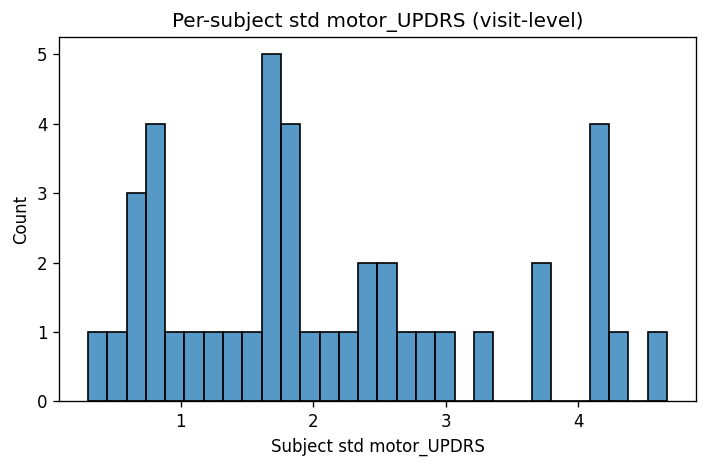

HNR          | overall_var=13.9035  between_subject_var=12.0222  ratio=0.86
NHR          | overall_var=0.0025  between_subject_var=0.0022  ratio=0.90
RPDE         | overall_var=0.0069  between_subject_var=0.0054  ratio=0.78
PPE          | overall_var=0.0055  between_subject_var=0.0043  ratio=0.79
Shimmer      | overall_var=0.0005  between_subject_var=0.0004  ratio=0.85
Jitter(%)    | overall_var=0.0000  between_subject_var=0.0000  ratio=0.52


In [7]:
# EDA 4 — Per-subject baseline and variability
subj_stats = (dfv_eda
              .groupby(subject_id)[voice_cols + [target]]
              .agg(['mean','std']))

# Flatten columns for convenience
subj_stats.columns = ['_'.join(col) for col in subj_stats.columns]

plt.figure(figsize=(6,4))
sns.histplot(subj_stats[f'{target}_mean'], bins=30, edgecolor='k')
plt.title("Per-subject mean motor_UPDRS (visit-level)")
plt.xlabel("Subject mean motor_UPDRS"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
sns.histplot(subj_stats[f'{target}_std'].fillna(0), bins=30, edgecolor='k')
plt.title("Per-subject std motor_UPDRS (visit-level)")
plt.xlabel("Subject std motor_UPDRS"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Approx. “between vs overall” variance for a few key features
def variance_decomp(feature):
    overall_var = dfv_eda[feature].var(ddof=1)
    means = dfv_eda.groupby(subject_id)[feature].mean()
    between_var = means.var(ddof=1)
    return feature, overall_var, between_var, between_var/overall_var if overall_var>0 else np.nan

for feat in ['HNR','NHR','RPDE','PPE','Shimmer','Jitter(%)']:
    f, ov, bv, ratio = variance_decomp(feat)
    print(f"{f:12s} | overall_var={ov:.4f}  between_subject_var={bv:.4f}  ratio={ratio:.2f}")

## EDA 5 — Outliers and Clipping Sanity

Quantiles are inspected across voice features, and before/after plots for a representative feature illustrate the impact of gentle clipping at extreme tails. Clipping trims only the most unusual values while keeping the natural shape of each distribution intact. The goal is not to “clean” away true signal, but to prevent rare extremes—often recording artifacts or transient noise—from dominating gradients during training and harming generalization.

,0.001,0.010,0.050,0.950,0.990,0.999
Jitter(%),0.001806,0.002324,0.002860,0.012144,0.024943,0.037259
Jitter(Abs),0.000005,0.000010,0.000015,0.000096,0.000147,0.000181
Jitter:RAP,0.000776,0.001045,0.001302,0.006381,0.012085,0.019159
Jitter:PPQ5,0.000851,0.001135,0.001438,0.006190,0.018947,0.027989
Jitter:DDP,0.002326,0.003137,0.003901,0.019143,0.036259,0.057477
Shimmer,0.006606,0.011622,0.013815,0.061218,0.151887,0.168839
Shimmer(dB),0.069980,0.108982,0.130575,0.545958,1.355863,1.479477
Shimmer:APQ3,0.003116,0.005394,0.006690,0.032476,0.068247,0.080630
Shimmer:APQ5,0.003523,0.006288,0.007676,0.036976,0.097628,0.116497
Shimmer:APQ11,0.004388,0.008783,0.010942,0.050687,0.108431,0.147104


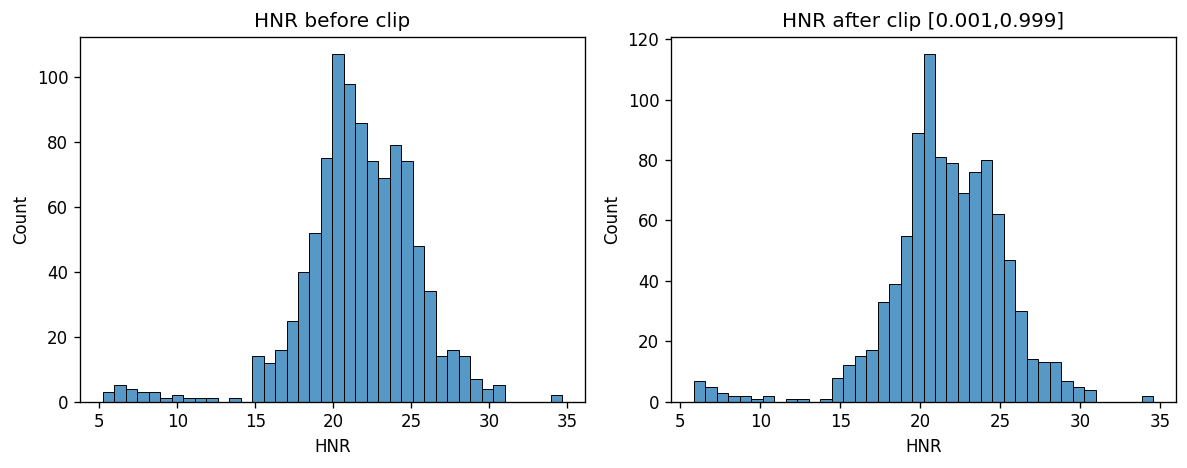

In [8]:
# EDA 5 — Outliers and clipping sanity
q_low, q_high = 0.001, 0.999
qtab = dfv_eda[voice_cols].quantile([q_low, 0.01, 0.05, 0.95, 0.99, q_high]).T
display(qtab)

probe = 'HNR'  # change to inspect another feature
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(dfv_eda[probe], bins=40, edgecolor='k', ax=ax[0])
ax[0].set_title(f"{probe} before clip")

tmp = dfv_eda.copy()
lo, hi = tmp[probe].quantile(q_low), tmp[probe].quantile(q_high)
tmp[probe] = tmp[probe].clip(lo, hi)
sns.histplot(tmp[probe], bins=40, edgecolor='k', ax=ax[1])
ax[1].set_title(f"{probe} after clip [{q_low:.3f},{q_high:.3f}]")

plt.tight_layout(); plt.show()

## EDA 6 — Target Dynamics and Naïve Baseline at Visit-Level

Visit-to-visit changes in motor_UPDRS (ΔUPDRS) are computed and visualized. The distribution is narrow and centered near zero, confirming that most short-horizon movements are small. The naïve “last value equals next value” baseline translates directly into the average absolute change and is therefore quite competitive. This evidence explains two design choices: train the model on ΔUPDRS to highlight subtle dynamics, and evaluate against a persistence baseline to ensure any claimed gains are meaningful.

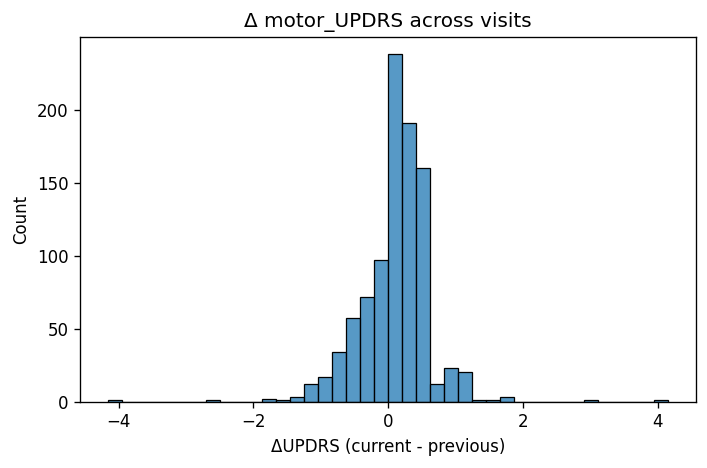

Naïve last-value baseline MAE (visit-level): 0.376
Share of visits with |ΔUPDRS| ≤ 1.0: 94.94%


In [9]:
# EDA 6 — Target dynamics and naïve baseline at visit-level
dfv_eda = dfv_eda.sort_values([subject_id, 'visit_day']).copy()
dfv_eda['motor_prev'] = dfv_eda.groupby(subject_id)[target].shift(1)
dfv_eda['motor_delta'] = dfv_eda[target] - dfv_eda['motor_prev']

# Distribution of ΔUPDRS between visits
plt.figure(figsize=(6,4))
sns.histplot(dfv_eda['motor_delta'].dropna(), bins=40, edgecolor='k')
plt.title("Δ motor_UPDRS across visits")
plt.xlabel("ΔUPDRS (current - previous)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Naïve last-value baseline MAE (predict current = previous)
naive_mae = np.abs(dfv_eda['motor_delta'].dropna()).mean()
print(f"Naïve last-value baseline MAE (visit-level): {naive_mae:.3f}")

# Share of small changes (stability signal)
small = dfv_eda['motor_delta'].dropna().abs() <= 1.0
print(f"Share of visits with |ΔUPDRS| ≤ 1.0: {small.mean():.2%}")

## EDA 7 — Autocorrelation of Level and of Deltas

Lag correlations are estimated within subjects for both the absolute level and the change series. The level shows strong positive autocorrelation over several lags, reflecting clinical persistence. The change series shows much weaker autocorrelation, which means that predicting the direction and size of the next change is inherently harder than predicting the level. This pattern supports the hybrid GRU–CNN approach, which blends longer temporal memory with local pattern extraction to detect non-persistent micro-signals.

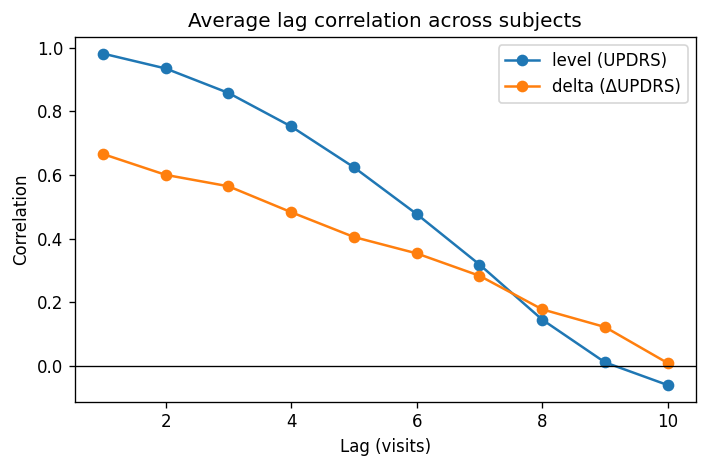

In [43]:
# EDA 7 — Autocorrelation of level and of deltas (robust, no warnings)
def lag_corr_safe(series, max_lag=10, min_len=4, eps=1e-12):
    """Return list of Pearson correlations at lags 1..max_lag.
    Skips lags where either slice is too short or has ~zero variance."""
    s = pd.Series(series).to_numpy(dtype=np.float64)
    vals = []
    for k in range(1, max_lag + 1):
        a, b = s[:-k], s[k:]
        if a.size < min_len or b.size < min_len:
            vals.append(np.nan)
            continue
        va, vb = a - a.mean(), b - b.mean()
        denom = va.std(ddof=0) * vb.std(ddof=0)
        if denom < eps:
            vals.append(np.nan)  # correlation undefined for near-constant slices
            continue
        vals.append(float((va * vb).mean() / denom))
    return vals

max_lag = 10
ac_level_list, ac_delta_list = [], []

for _, g in dfv_eda.groupby(subject_id):
    g = g.sort_values('visit_day')
    level = g[target].dropna()
    delta = g['motor_delta'].dropna()
    if len(level) > max_lag + 1:
        ac_level_list.append(lag_corr_safe(level, max_lag=max_lag))
    if len(delta) > max_lag + 1:
        ac_delta_list.append(lag_corr_safe(delta, max_lag=max_lag))

# Average across subjects, guarding against empty lists
if ac_level_list:
    ac_level = np.nanmean(np.array(ac_level_list, dtype=np.float64), axis=0)
else:
    ac_level = np.full(max_lag, np.nan)

if ac_delta_list:
    ac_delta = np.nanmean(np.array(ac_delta_list, dtype=np.float64), axis=0)
else:
    ac_delta = np.full(max_lag, np.nan)

plt.figure(figsize=(6, 4))
plt.plot(range(1, max_lag + 1), ac_level, marker='o', label='level (UPDRS)')
plt.plot(range(1, max_lag + 1), ac_delta, marker='o', label='delta (ΔUPDRS)')
plt.axhline(0, color='k', lw=0.8)
plt.title("Average lag correlation across subjects")
plt.xlabel("Lag (visits)"); plt.ylabel("Correlation")
plt.legend(); plt.tight_layout(); plt.show()

## EDA 8 — Lag-1 Feature–Change Correlations (Spearman)

Within each subject, features at time t are aligned to the next-visit change at time t+1 and ranked by Spearman correlation. Individual features show only modest monotonic relationships to future ΔUPDRS, which suggests that short-term progression is not driven by a single dominant marker. The model therefore needs to combine many weak cues and let temporal context modulate their importance rather than over-relying on any one acoustic measure.

,spearman_corr_to_next_delta
NHR,0.081276
HNR,0.047860
Shimmer:DDA,0.044493
Shimmer:APQ3,0.044479
Shimmer(dB),0.033180
Shimmer,0.026655
Shimmer:APQ5,0.018975
Jitter:DDP,0.004943
Jitter:RAP,0.004915
Shimmer:APQ11,-0.016584


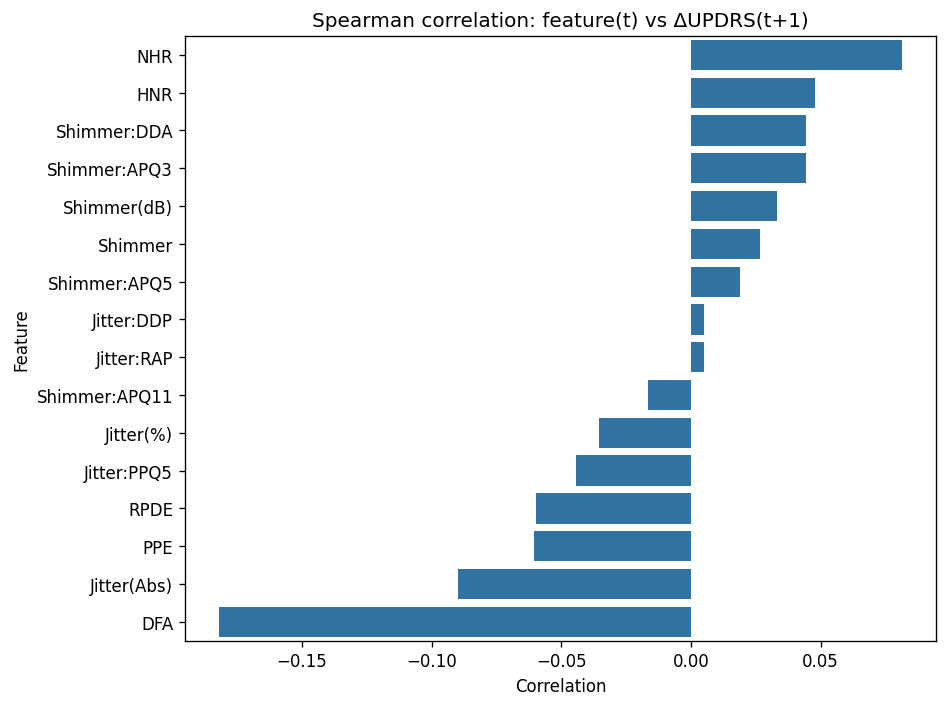

In [11]:
# EDA 8 — Feature → next change (lag-1) correlations (Spearman)
# Align features at time t with ΔUPDRS at time t+1 within subject
pairs = []
for pid, g in dfv_eda.groupby(subject_id):
    g = g.sort_values('visit_day')
    ft = g[voice_cols].iloc[:-1].reset_index(drop=True)
    dy = g['motor_delta'].iloc[1:].reset_index(drop=True)
    ft['__delta_next__'] = dy
    pairs.append(ft)

lag_df = pd.concat(pairs, axis=0, ignore_index=True).dropna()
corr_spear = lag_df.corr(method='spearman')['__delta_next__'].drop('__delta_next__').sort_values(ascending=False)
display(corr_spear.to_frame('spearman_corr_to_next_delta'))

plt.figure(figsize=(8,6))
sns.barplot(x=corr_spear.values, y=corr_spear.index, orient='h')
plt.title("Spearman correlation: feature(t) vs ΔUPDRS(t+1)")
plt.xlabel("Correlation"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

## EDA 9 — Mutual Information: Feature(t) → ΔUPDRS(t+1)

Mutual information provides a non-linear ranking of how informative each feature is about the next change. Several features carry small but real bits of information, consistent with the correlation view yet capturing non-monotonic dependencies the rank metric cannot. This result further motivates a non-linear, sequence-aware model that can discover interactions across features and time.

,mutual_information
DFA,0.319713
Jitter(Abs),0.247287
Shimmer:APQ5,0.245497
Jitter:PPQ5,0.239898
PPE,0.239061
Shimmer(dB),0.238066
Shimmer:APQ11,0.231677
Shimmer:DDA,0.224569
Shimmer:APQ3,0.223913
Shimmer,0.220465


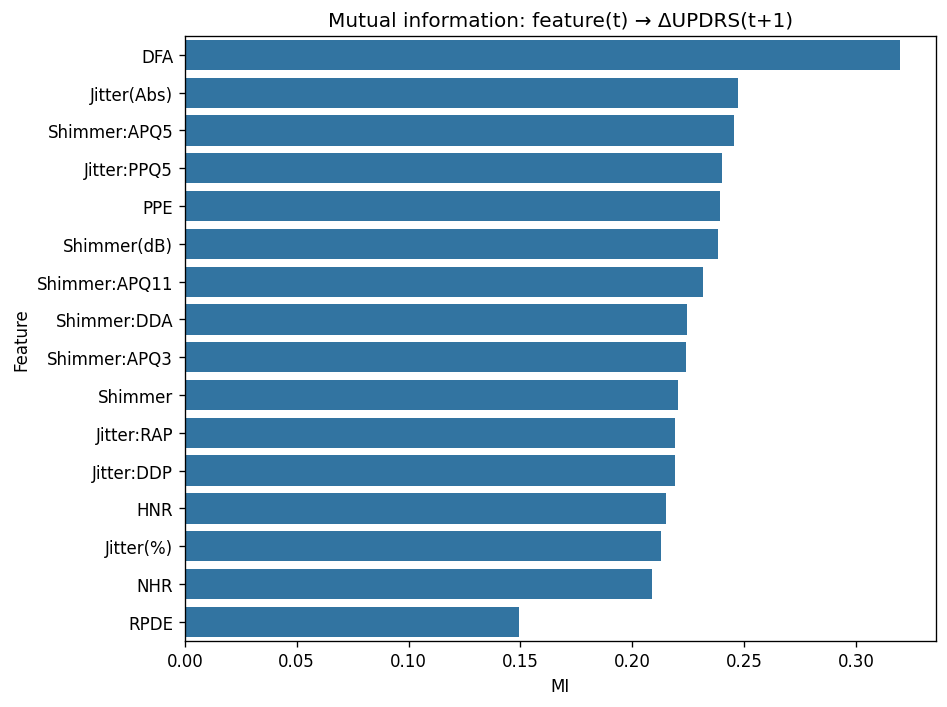

In [12]:
# EDA 9 — Mutual information ranking: feature(t) → ΔUPDRS(t+1)
X_mi = lag_df[voice_cols].to_numpy()
y_mi = lag_df['__delta_next__'].to_numpy()
mi = mutual_info_regression(X_mi, y_mi, random_state=42)
mi_series = pd.Series(mi, index=voice_cols).sort_values(ascending=False)
display(mi_series.to_frame('mutual_information'))

plt.figure(figsize=(8,6))
sns.barplot(x=mi_series.values, y=mi_series.index, orient='h')
plt.title("Mutual information: feature(t) → ΔUPDRS(t+1)")
plt.xlabel("MI"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

## EDA 10 — Trajectories for Sample Subjects

Selected subjects’ motor_UPDRS trajectories are plotted across visits. Most curves are smooth with occasional steps, again highlighting a dominant stability signal. These plots offer an immediate, intuitive anchor for stakeholders: over short windows, the best forecast is often “no change,” and the job of the model is to identify the exceptions where voice dynamics hint at drift.

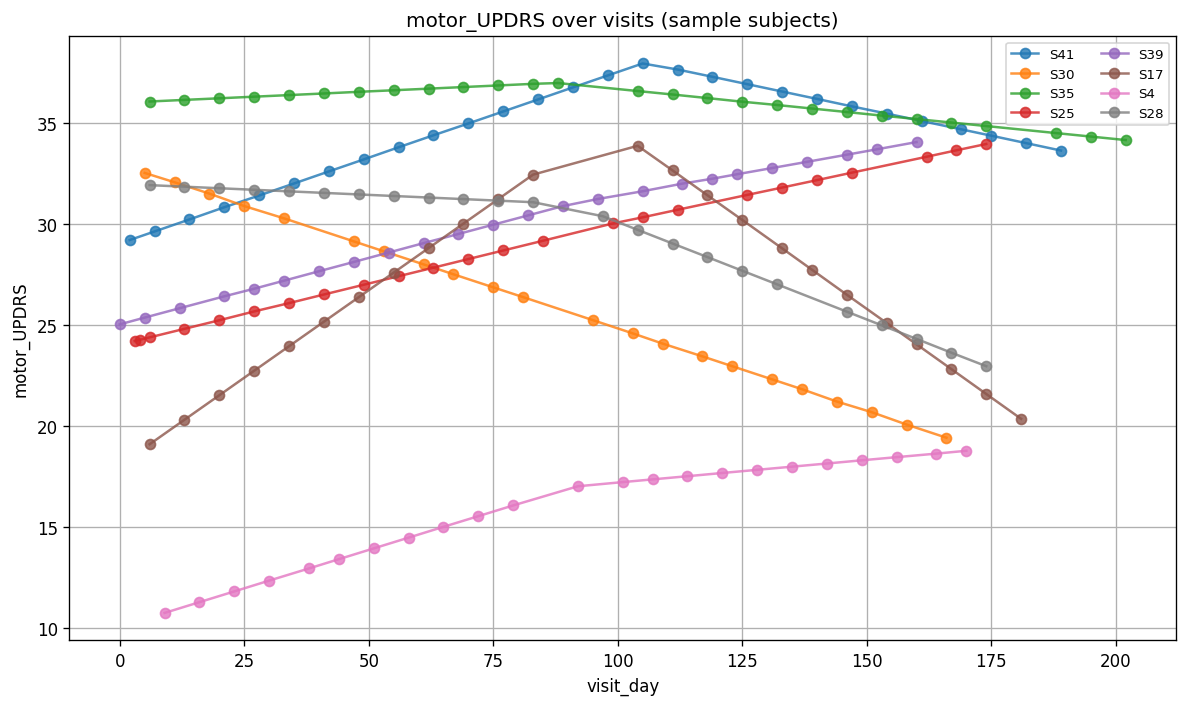

In [13]:
# EDA 10 — Trajectories for a few subjects
rng = np.random.default_rng(42)
sample_subjects = rng.choice(dfv_eda[subject_id].unique(), size=min(8, dfv_eda[subject_id].nunique()), replace=False)

plt.figure(figsize=(10,6))
for pid in sample_subjects:
    g = dfv_eda[dfv_eda[subject_id]==pid].sort_values('visit_day')
    plt.plot(g['visit_day'], g[target], marker='o', alpha=0.8, label=f"S{pid}")
plt.title("motor_UPDRS over visits (sample subjects)")
plt.xlabel("visit_day"); plt.ylabel("motor_UPDRS"); plt.grid(True); plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

## EDA 11 — Feature–Feature and Feature–Target Structure

A visit-level Spearman heatmap maps relationships among voice features and their associations with motor_UPDRS. Families such as jitter and shimmer cluster together, indicating shared variance that the model can compress. Direct feature–target links are moderate, which aligns with earlier findings and reinforces the need to pool information across features and across time. Pairwise scatter views of the top correlates show gentle monotonic trends with visible spread, reminding us that simple linear rules will leave performance on the table.

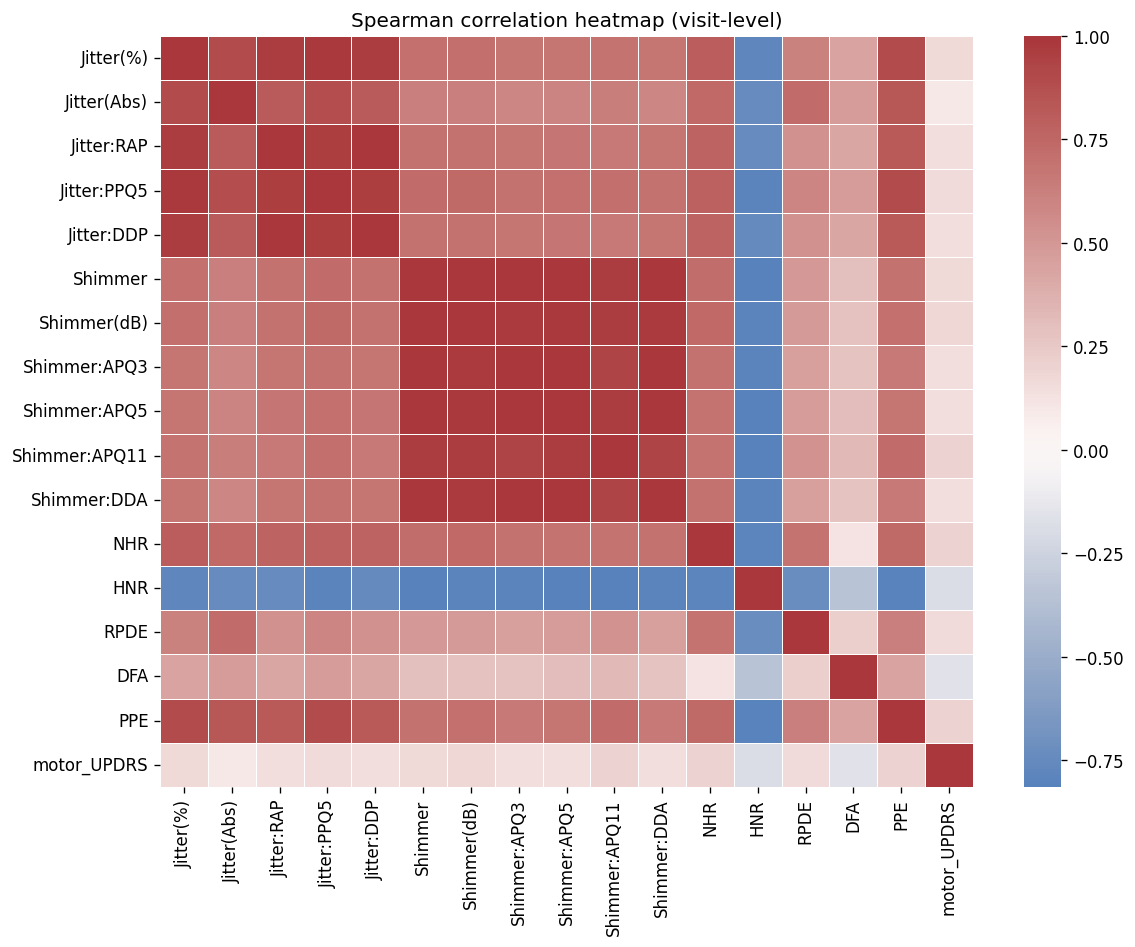

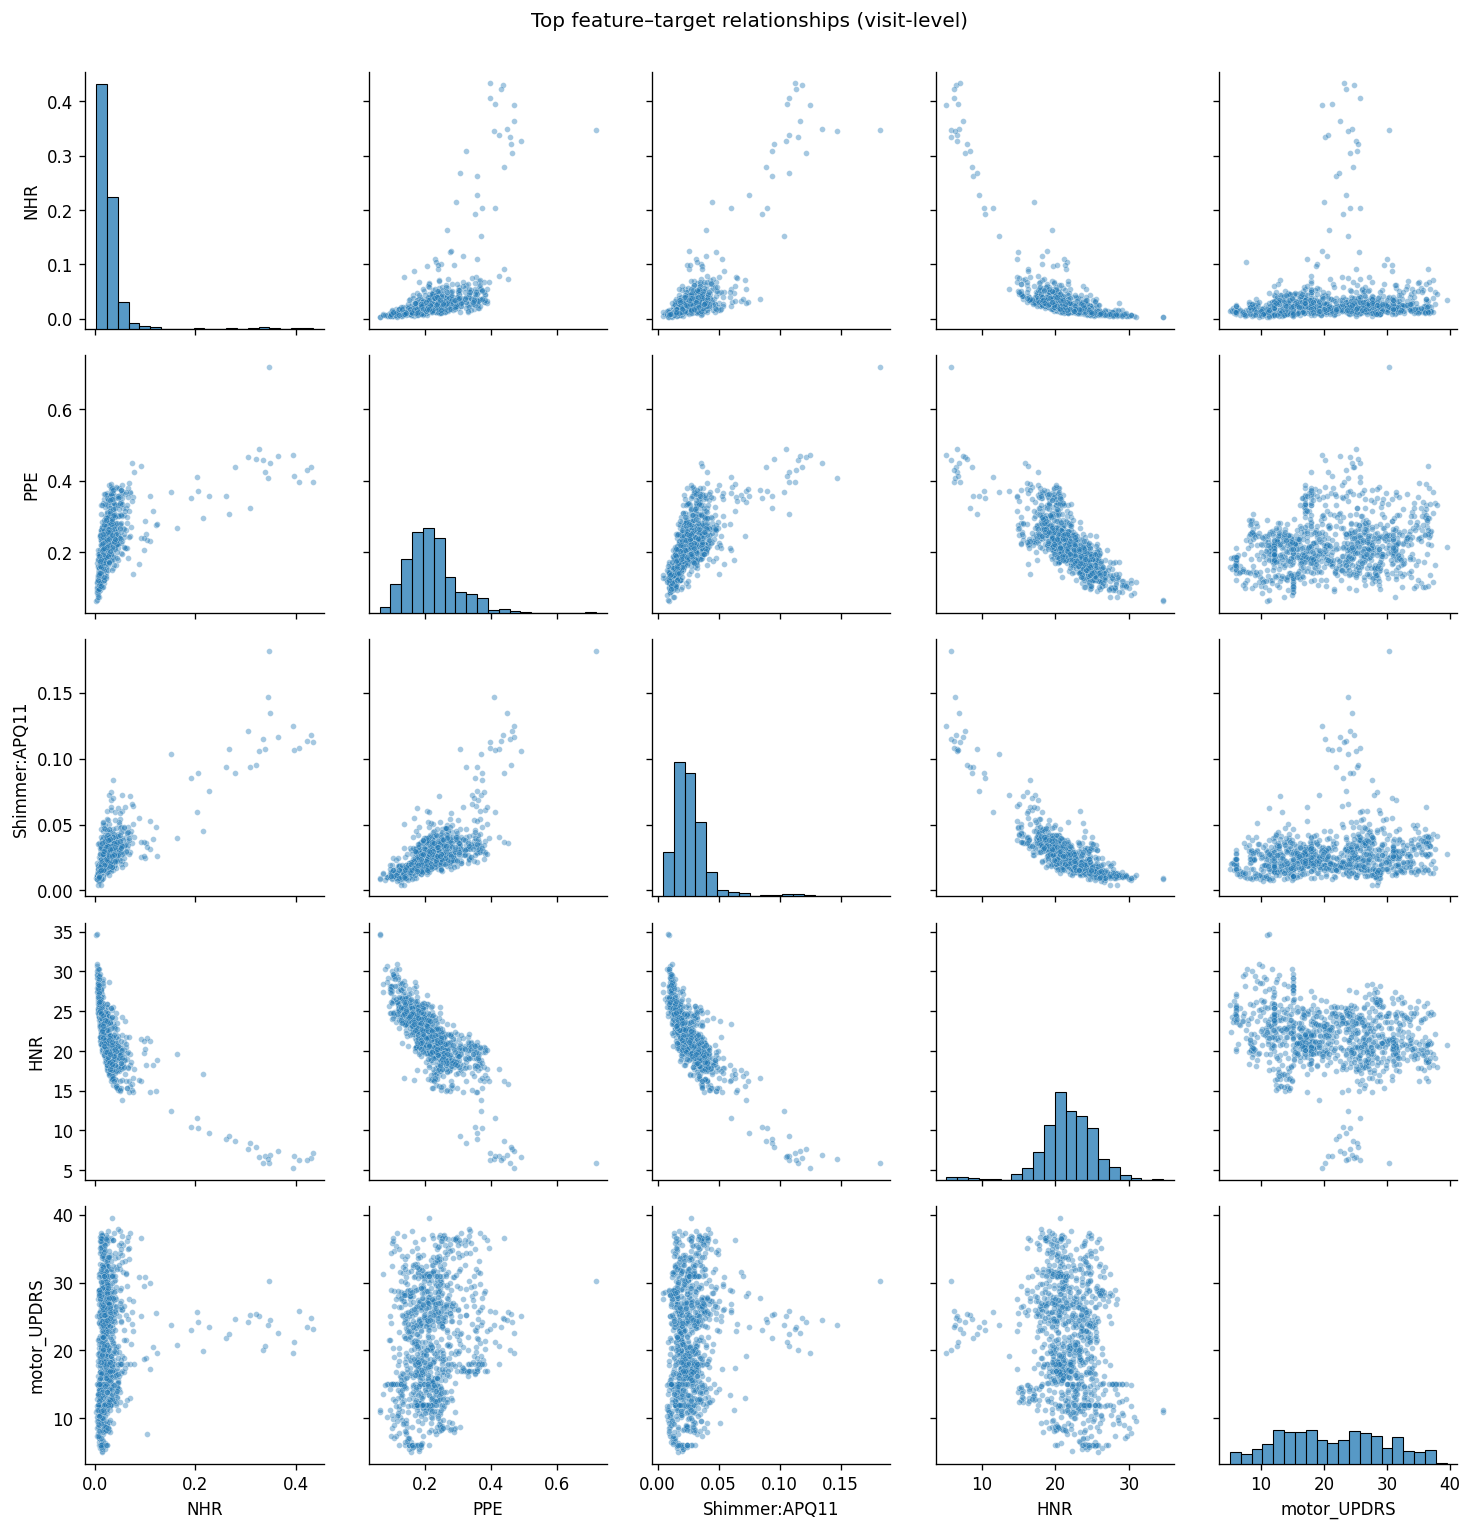

In [14]:
# EDA 11 — Feature–feature and feature–target correlations (visit-level)
corr = dfv_eda[voice_cols + [target]].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='vlag', center=0, linewidths=0.5)
plt.title("Spearman correlation heatmap (visit-level)")
plt.tight_layout(); plt.show()

# Quick scatter for a few top correlates to visualize monotonic trends
top_feats = corr[target].drop(target).abs().sort_values(ascending=False).head(4).index.tolist()
g = sns.PairGrid(dfv_eda[top_feats + [target]].sample(min(1500, len(dfv_eda)), random_state=42))
g.map_diag(sns.histplot, bins=20, edgecolor='k')
g.map_offdiag(sns.scatterplot, s=12, alpha=0.4)
plt.suptitle("Top feature–target relationships (visit-level)", y=1.02)
plt.show()

## Visit-Level Aggregation Confirmation

A final check compares the row count before and after aggregation and reports the average number of visits per subject. The reduction confirms that repeated phonations within the same day have been properly collapsed, ensuring that each training example represents a single clinical visit. This guarantees fair weighting across subjects and visits and prepares a clean foundation for leakage-safe sequence building, cross-validation, and model training.

In [15]:
# Verify duplicate rows per visit on the raw table
dup_counts = (df.assign(visit_day=np.floor(df[time_var]).astype(int))
                .groupby([subject_id,'visit_day']).size())
print(dup_counts.describe())
print(dup_counts.value_counts().head())


# Visit-Level Aggregation (one row per subject×day)
base_cols = voice_features + [target, subject_id, time_var]
raw = df[base_cols].copy()
raw[time_var_day] = np.floor(raw[time_var]).astype(int)

agg_dict = {c: 'mean' for c in voice_features}
agg_dict.update({target: 'mean', time_var: 'mean'})  # mean test_time just for reference

df_visit = (raw
            .groupby([subject_id, time_var_day], as_index=False)
            .agg(agg_dict)
            .sort_values([subject_id, time_var_day])
            .reset_index(drop=True))

print("Rows before:", len(df), " | after visit aggregation:", len(df_visit))
print("Mean visits per subject:", df_visit.groupby(subject_id).size().mean())

count    990.000000
mean       5.934343
std        0.495411
min        3.000000
25%        6.000000
50%        6.000000
75%        6.000000
max       12.000000
dtype: float64
6     909
5      68
4       7
12      3
3       2
Name: count, dtype: int64
Rows before: 5875  | after visit aggregation: 990
Mean visits per subject: 23.571428571428573


#**FEATURE ENGINEERING**

# Temporal Feature Engineering

Two families of temporal descriptors are added for each voice feature. First-order differences within each subject emphasize how a feature is changing rather than where it sits, while short rolling means smooth transient fluctuations and reduce sensor noise. These engineered variables enrich the temporal context and improve signal-to-noise for short-horizon forecasting.

In [16]:
# Temporal Feature Engineering
dfv = df_visit.copy()

# First-order deltas (across visits within subject)
delta_cols = []
for col in voice_features:
    dcol = f"{col}_delta"
    dfv[dcol] = dfv.groupby(subject_id)[col].diff()
    delta_cols.append(dcol)

# Rolling mean (3 visits) within subject
smooth_cols = []
for col in voice_features:
    scol = f"{col}_roll3"
    dfv[scol] = dfv.groupby(subject_id)[col].transform(lambda s: s.rolling(window=3, min_periods=1).mean())
    smooth_cols.append(scol)

# Fill NaNs introduced by differencing/rolling
for col in delta_cols:
    dfv[col] = dfv[col].fillna(0.0)
for col in smooth_cols:
    dfv[col] = (dfv.groupby(subject_id)[col]
                  .apply(lambda s: s.ffill().bfill())
                  .reset_index(level=0, drop=True))
    if dfv[col].isna().any():
        dfv[col] = dfv[col].fillna(dfv[col].mean())

aug_features = voice_features + delta_cols + smooth_cols

# Clip extremes per column
def clip_per_column(frame, cols, low_q=0.001, high_q=0.999):
    for c in cols:
        lo = frame[c].quantile(low_q); hi = frame[c].quantile(high_q)
        frame[c] = frame[c].clip(lo, hi)
    return frame
dfv = clip_per_column(dfv, aug_features, 0.001, 0.999)

# Per-Subject Normalization

All features are z-scored within each subject’s time series, subtracting that subject’s mean and dividing by that subject’s standard deviation. This centers learning on within-person dynamics and reduces confounding from baseline differences in voice, age, sex, or recording hardware. Light clipping keeps rare extremes from dominating gradients while preserving natural variability.

In [17]:
# Per-Subject Z-Scoring
eps = 1e-6
for col in aug_features:
    subj_mean = dfv.groupby(subject_id)[col].transform('mean')
    subj_std  = dfv.groupby(subject_id)[col].transform('std').fillna(0.0)
    subj_std_safe = subj_std.mask(subj_std < eps, 1.0)
    dfv[col] = (dfv[col] - subj_mean) / subj_std_safe

dfv[aug_features] = dfv[aug_features].clip(-5, 5).astype('float32')
row_mask = np.isfinite(dfv[aug_features].to_numpy()).all(axis=1) & np.isfinite(dfv[target].to_numpy())
dfv = dfv.loc[row_mask].copy()

#**BUILDING AND TRAINING THE MODEL**

# Helper Functions for Sequence Building, Scaling, and Model Definition

Sliding windows are built per subject in temporal order. Each training sample contains a short sequence of engineered and normalized voice features, the label is the next-visit ΔUPDRS, and the last observed absolute score is carried forward so the model’s delta prediction can be reconstructed to an absolute next-visit forecast at inference time. This design cleanly separates dynamic learning from baseline restoration.

In [18]:
# Helper functions
def build_sequences_delta(df_like, features, seq_len, subject_id, time_key, target):
    X, y_delta, y_abs, last_y, groups = [], [], [], [], []
    for pid, g in df_like.groupby(subject_id):
        g = g.sort_values(time_key)
        feats = g[features].values.astype(np.float32)
        targs = g[target].values.astype(np.float32)
        if len(feats) < seq_len + 1:
            continue
        for i in range(len(feats) - seq_len):
            X.append(feats[i:i+seq_len])
            y_last = targs[i+seq_len-1]
            y_next = targs[i+seq_len]
            y_delta.append(y_next - y_last)
            y_abs.append(y_next)
            last_y.append(y_last)
            groups.append(pid)
    X = np.asarray(X, dtype=np.float32)
    y_delta = np.asarray(y_delta, dtype=np.float32)
    y_abs = np.asarray(y_abs, dtype=np.float32)
    last_y = np.asarray(last_y, dtype=np.float32)
    groups = np.asarray(groups)
    mask = np.isfinite(X).all(axis=(1,2)) & np.isfinite(y_delta) & np.isfinite(y_abs) & np.isfinite(last_y)
    return X[mask], y_delta[mask], y_abs[mask], last_y[mask], groups[mask]

def safe_standardize_train_fit(X_tr):
    n,t,f = X_tr.shape
    flat = X_tr.reshape(-1, f).astype(np.float64)
    mean = flat.mean(axis=0)
    std  = flat.std(axis=0)
    std_safe = np.where(std < 1e-8, 1.0, std)
    return mean.astype(np.float32), std_safe.astype(np.float32)

def safe_standardize_transform(X, mean, std):
    n,t,f = X.shape
    flat = X.reshape(-1, f).astype(np.float32)
    flat = (flat - mean) / std
    return flat.reshape(n,t,f).astype(np.float32)

def build_model(seq_len, n_feat, l2=1e-3):
    inp = keras.Input(shape=(seq_len, n_feat))
    r = layers.Bidirectional(layers.GRU(32, return_sequences=True))(inp)
    r = layers.Dropout(0.4)(r)
    r = layers.LayerNormalization()(r)
    r = layers.GlobalAveragePooling1D()(r)
    r = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2))(r)
    c = layers.Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(inp)
    c = layers.Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(c)
    c = layers.GlobalAveragePooling1D()(c)
    c = layers.Dropout(0.4)(c)
    x = layers.Concatenate()([r, c])
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inp, out)
    opt = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=opt, loss=keras.losses.Huber(), metrics=['mae'])
    return model

# Hyperparameter Search Strategy (Visit-Level)

This section tunes the temporal footprint and regularization of the hybrid GRU–CNN by running grouped cross-validation on the visit-level table. Each candidate pairs a sequence length—the number of consecutive visits used as input—with an L2 penalty that controls model capacity. To accelerate training on GPU, automatic mixed precision is enabled when available. Because patients contribute multiple observations, folds are built with GroupKFold by subject so no patient appears in both training and validation within a fold. The objective is mean absolute error (MAE) on absolute motor_UPDRS, computed by predicting the next change (ΔUPDRS) and reconstructing the absolute value from the last known measurement, aligning evaluation with the clinical target scale.

In [19]:
# Hyperparameter search (on VISIT-LEVEL dfv)

# Enable mixed precision on A100 for extra speed
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)


# Knobs for speed vs. thoroughness
CV_FOLDS      = 5
MAX_EPOCHS_CV = 40
PATIENCE_CV   = 4
BATCH_CV      = 128
sequence_grid = [5, 7, 9]
l2_grid       = [1e-3, 3e-4]

# Precompute sequences once per seq_len using VISIT-LEVEL time key
seq_cache = {}
for seq_len in sequence_grid:
    X, y_delta, y_abs, last_y, groups = build_sequences_delta(
        dfv, aug_features, seq_len, subject_id, time_var_day, target
    )
    seq_cache[seq_len] = (X, y_delta, y_abs, last_y, groups)
    print(f"Prepared sequences (VISIT) for seq_len={seq_len}: X={X.shape}, y_delta={y_delta.shape}")

def cv_score_for_params_cached(seq_len, l2, debug=False):
    X, y_delta, y_abs, last_y, groups = seq_cache[seq_len]
    gkf = GroupKFold(n_splits=CV_FOLDS)
    fold_maes = []

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y_delta, groups)):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y_delta[tr_idx], y_delta[va_idx]
        last_va, y_va_abs = last_y[va_idx], y_abs[va_idx]

        mean, std = safe_standardize_train_fit(X_tr)
        X_tr_s = safe_standardize_transform(X_tr, mean, std)
        X_va_s = safe_standardize_transform(X_va, mean, std)

        ds_tr = tf.data.Dataset.from_tensor_slices((X_tr_s, y_tr)).batch(BATCH_CV).prefetch(tf.data.AUTOTUNE)
        ds_va = tf.data.Dataset.from_tensor_slices((X_va_s, y_va)).batch(BATCH_CV).prefetch(tf.data.AUTOTUNE)

        model = build_model(seq_len, X_tr_s.shape[-1], l2=l2)
        early  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_CV, restore_best_weights=True, verbose=0)
        reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=max(1, PATIENCE_CV//2), min_lr=1e-6, verbose=0)

        model.fit(ds_tr, validation_data=ds_va, epochs=MAX_EPOCHS_CV, callbacks=[early, reduce], verbose=0)

        delta_va_pred = model.predict(ds_va, verbose=0).astype('float32').flatten()
        y_va_pred_abs = last_va + delta_va_pred
        mae = mean_absolute_error(y_va_abs, y_va_pred_abs)
        fold_maes.append(mae)

        if debug and fold == 0:
            print(f"[sanity] ABS range: {y_va_abs.min():.2f}..{y_va_abs.max():.2f} | Δpred mean: {delta_va_pred.mean():.3f}")

    return float(np.mean(fold_maes)), fold_maes

# Run the search with timing
start = time.time()
results = []

for seq_len in sequence_grid:
    for l2 in l2_grid:
        mean_mae, per_fold = cv_score_for_params_cached(seq_len, l2, debug=True)
        results.append({"seq_len": seq_len, "l2": l2, "cv_mae": mean_mae, "folds": np.round(per_fold,3).tolist()})
        print(f"seq={seq_len}, l2={l2:.1e} -> mean CV MAE={mean_mae:.3f} | folds={np.round(per_fold,3)}")

print(f"Total CV time: {(time.time()-start)/60:.1f} min")

results_df = pd.DataFrame(results).sort_values("cv_mae").reset_index(drop=True)
best_seq = int(results_df.iloc[0]["seq_len"])
best_l2  = float(results_df.iloc[0]["l2"])
print("\nBest params:", {"seq_len": best_seq, "l2": best_l2})
display(results_df)

Mixed precision enabled.
Prepared sequences (VISIT) for seq_len=5: X=(780, 5, 48), y_delta=(780,)
Prepared sequences (VISIT) for seq_len=7: X=(696, 7, 48), y_delta=(696,)
Prepared sequences (VISIT) for seq_len=9: X=(612, 9, 48), y_delta=(612,)
[sanity] ABS range: 6.01..37.96 | Δpred mean: 0.051


seq=5, l2=1.0e-03 -> mean CV MAE=0.379 | folds=[0.505 0.439 0.342 0.385 0.222]
[sanity] ABS range: 6.01..37.96 | Δpred mean: 0.101
seq=5, l2=3.0e-04 -> mean CV MAE=0.390 | folds=[0.527 0.436 0.333 0.422 0.229]
[sanity] ABS range: 6.01..37.96 | Δpred mean: 0.136
seq=7, l2=1.0e-03 -> mean CV MAE=0.402 | folds=[0.522 0.489 0.341 0.399 0.259]
[sanity] ABS range: 6.01..37.96 | Δpred mean: 0.109
seq=7, l2=3.0e-04 -> mean CV MAE=0.399 | folds=[0.506 0.471 0.339 0.424 0.254]
[sanity] ABS range: 6.23..37.96 | Δpred mean: 0.086
seq=9, l2=1.0e-03 -> mean CV MAE=0.388 | folds=[0.475 0.45  0.33  0.417 0.271]
[sanity] ABS range: 6.23..37.96 | Δpred mean: 0.038
seq=9, l2=3.0e-04 -> mean CV MAE=0.416 | folds=[0.549 0.475 0.335 0.464 0.258]
Total CV time: 3.9 min

Best params: {'seq_len': 5, 'l2': 0.001}


,seq_len,l2,cv_mae,folds
0,5,0.0010,0.378521,"[0.505, 0.439, 0.342, 0.385, 0.222]"
1,9,0.0010,0.388493,"[0.475, 0.45, 0.33, 0.417, 0.271]"
2,5,0.0003,0.389583,"[0.527, 0.436, 0.333, 0.422, 0.229]"
3,7,0.0003,0.398864,"[0.506, 0.471, 0.339, 0.424, 0.254]"
4,7,0.0010,0.402129,"[0.522, 0.489, 0.341, 0.399, 0.259]"
5,9,0.0003,0.416182,"[0.549, 0.475, 0.335, 0.464, 0.258]"


# Final Training on Train+Val and Subject-Held-Out Testing

After hyperparameters are fixed, the dataset is split by subject into training, validation, and testing cohorts. The training and validation cohorts are merged to maximize the data used to fit the final model. Standardization is refit on this merged set and applied to both the training and the held-out test subjects. A small internal holdout slice from the merged set is reserved for early stopping, ensuring the final model’s training dynamics remain monitored without touching the true test set. Performance is then reported on the patient-disjoint test cohort in UPDRS points.

In [20]:
# Final Train on Train+Val (VISIT-LEVEL), Evaluate on Test
X_all, y_delta_all, y_abs_all, last_y_all, groups_all = build_sequences_delta(
    dfv, aug_features, best_seq, subject_id, time_var_day, target
)

unique_subjects = np.unique(groups_all)
rng = np.random.default_rng(SEED); rng.shuffle(unique_subjects)
n_train = int(len(unique_subjects) * 0.70)
n_val   = int(len(unique_subjects) * 0.15)

train_subj = unique_subjects[:n_train]
val_subj   = unique_subjects[n_train:n_train+n_val]
test_subj  = unique_subjects[n_train+n_val:]

train_idx = np.isin(groups_all, train_subj)
val_idx   = np.isin(groups_all, val_subj)
test_idx  = np.isin(groups_all, test_subj)

In [21]:
# Merge Train+Val
trval_idx = train_idx | val_idx
X_trval, y_trval_delta = X_all[trval_idx], y_delta_all[trval_idx]
X_test,  y_test_abs    = X_all[test_idx],  y_abs_all[test_idx]
last_y_test            = last_y_all[test_idx]

mean, std = safe_standardize_train_fit(X_trval)
X_trval_s = safe_standardize_transform(X_trval, mean, std)
X_test_s  = safe_standardize_transform(X_test,  mean, std)

final_model = build_model(best_seq, X_trval_s.shape[-1], l2=best_l2)
early  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [22]:
# Small holdout from Train+Val for early stopping
n_hold = max(1, int(0.05 * len(X_trval_s)))
X_hold, y_hold = X_trval_s[:n_hold], y_trval_delta[:n_hold]
X_train_s, y_train_s = X_trval_s[n_hold:], y_trval_delta[n_hold:]

final_model.fit(X_train_s, y_train_s, validation_data=(X_hold, y_hold),
                epochs=120, batch_size=32, callbacks=[early, reduce], verbose=1)

delta_test_pred = final_model.predict(X_test_s, verbose=0).flatten()
y_test_pred_abs = last_y_test + delta_test_pred

deep_test_mae   = mean_absolute_error(y_test_abs, y_test_pred_abs)
print(f"\nDeep (visit-level) | Test MAE: {deep_test_mae:.3f} [seq={best_seq}, l2={best_l2}]")

Epoch 1/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.3601 - mae: 0.5209 - val_loss: 0.3036 - val_mae: 0.4762 - learning_rate: 1.0000e-04
Epoch 2/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3216 - mae: 0.4518 - val_loss: 0.2349 - val_mae: 0.3557 - learning_rate: 1.0000e-04
Epoch 3/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3135 - mae: 0.4341 - val_loss: 0.2172 - val_mae: 0.3181 - learning_rate: 1.0000e-04
Epoch 4/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3106 - mae: 0.4328 - val_loss: 0.2124 - val_mae: 0.3100 - learning_rate: 1.0000e-04
Epoch 5/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2973 - mae: 0.4125 - val_loss: 0.2090 - val_mae: 0.3027 - learning_rate: 1.0000e-04
Epoch 6/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2915 - mae: 0.3995 - val_loss: 0.2080 - val_mae: 0.3020 - learning_rate: 1.0000e-04
Epoch 7/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2807 - mae: 0.3867 - val_loss: 0.2064 - val_mae: 0.2979 - lear

#**MODEL EVALUATION**

# Baseline Definitions and Comparators

Two baselines anchor interpretation. The naïve baseline assumes no change and simply carries the last UPDRS forward, a strong yardstick when short-interval visits are often stable. The linear baseline is a Ridge regression trained on the same standardized sequences to predict ΔUPDRS, then reconstructed to absolute UPDRS. Comparing the deep model against both baselines clarifies whether temporal feature learning adds value beyond inertia and linear effects.

In [44]:
# Baselines
naive_test_mae = mean_absolute_error(y_test_abs, last_y_test)
ridge = Ridge(alpha=1.0, random_state=SEED)
ridge.fit(X_trval_s.reshape(len(X_trval_s), -1), y_trval_delta)
ridge_delta_test = ridge.predict(X_test_s.reshape(len(X_test_s), -1))
ridge_test_abs   = last_y_test + ridge_delta_test
ridge_test_mae   = mean_absolute_error(y_test_abs, ridge_test_abs)
print(f"Naive last-value  | Test MAE: {naive_test_mae:.3f}")
print(f"Ridge (delta→abs) | Test MAE: {ridge_test_mae:.3f}")

Naive last-value  | Test MAE: 0.427
Ridge (delta→abs) | Test MAE: 0.481


#Absolute Error Analysis and Subject-Level Summaries

Beyond a single MAE, absolute errors are compared case-by-case against the naïve baseline, and the share of test cases where the model wins is reported. Errors are then aggregated by subject to summarize typical performance and identify heterogeneity across patients. These subject-level views highlight where the model delivers meaningful gains and where it may struggle, informing future feature or architecture refinements.

In [45]:
# Model vs Naïve absolute error comparison

abs_err_model = np.abs(y_test_pred_abs - y_test_abs)
abs_err_naive = np.abs(last_y_test     - y_test_abs)
impr = abs_err_naive - abs_err_model  # >0 means model beats naive

print(f"Mean MAE — Model: {abs_err_model.mean():.3f} | Naive: {abs_err_naive.mean():.3f}")
print(f"Median MAE — Model: {np.median(abs_err_model):.3f} | Naive: {np.median(abs_err_naive):.3f}")
print(f"Share of test cases where model is better than naive: {(impr > 0).mean():.2%}")

# Per-subject MAE summary
test_subjects = groups_all[test_idx]
per_subj = pd.DataFrame({
    "subject": test_subjects,
    "err_model": abs_err_model,
    "err_naive": abs_err_naive,
    "improvement": impr
}).groupby("subject").mean().sort_values("improvement", ascending=False)

print("\nPer-subject MAE (head):")
display(per_subj.head(10))
print("\nPer-subject MAE (tail):")
display(per_subj.tail(10))

print("\nPer-subject improvement summary:")
display(per_subj["improvement"].describe())

Mean MAE — Model: 0.433 | Naive: 0.427
Median MAE — Model: 0.440 | Naive: 0.423
Share of test cases where model is better than naive: 43.66%

Per-subject MAE (head):


,err_model,err_naive,improvement
subject,,,
2,0.274078,0.358800,0.084722
9,0.145071,0.225897,0.080825
37,0.568255,0.593316,0.025061
41,0.490298,0.471891,-0.018407
3,0.288362,0.248500,-0.039862
14,0.678719,0.598336,-0.080382
34,0.597352,0.507204,-0.090147



Per-subject MAE (tail):


,err_model,err_naive,improvement
subject,,,
2,0.274078,0.358800,0.084722
9,0.145071,0.225897,0.080825
37,0.568255,0.593316,0.025061
41,0.490298,0.471891,-0.018407
3,0.288362,0.248500,-0.039862
14,0.678719,0.598336,-0.080382
34,0.597352,0.507204,-0.090147



Per-subject improvement summary:


,improvement
count,7.000000
mean,-0.005456
std,0.071468
min,-0.090147
25%,-0.060122
50%,-0.018407
75%,0.052943
max,0.084722


#Statistical Significance of Improvements

To assess whether improvements over the naïve baseline are unlikely to be due to chance, two paired nonparametric tests are applied. The Wilcoxon signed-rank test evaluates whether the median reduction in absolute error is positive. A complementary sign test counts the number of test cases where the model beats the baseline and compares it to a fair coin. Together, these tests provide a robust, distribution-free check on practical significance.

In [47]:
# Significance: paired nonparametric tests
try:
    # Wilcoxon on paired absolute errors (tests median improvement > 0)
    w = wilcoxon(abs_err_naive, abs_err_model, zero_method='wilcox', alternative='greater', mode='approx')
    # Binomial sign test on number of wins
    n_better = int((impr > 0).sum()); n_worse = int((impr < 0).sum())
    p_sign = binomtest(n_better, n_better + n_worse, p=0.5, alternative='greater').pvalue
    print(f"\nWilcoxon signed-rank (naive > model): statistic={w.statistic:.1f}, p={w.pvalue:.4f}")
    print(f"Sign test (wins against naive): n_better={n_better}, n_worse={n_worse}, p={p_sign:.4f}")
except Exception as e:
    print("\nSignificance tests skipped (scipy not available):", e)


Wilcoxon signed-rank (naive > model): statistic=4867.5, p=0.6648
Sign test (wins against naive): n_better=62, n_worse=80, p=0.9447


#Uncertainty Estimation via Bootstrap Confidence Intervals

Model and baseline MAEs are accompanied by nonparametric bootstrap confidence intervals. By resampling test cases with replacement many times, the bootstrap approximates the sampling distribution of the MAE and yields 95% intervals. These intervals communicate uncertainty in the reported point estimates and help judge whether observed differences are meaningful.

In [48]:
# Simple bootstrap CIs on MAE
def bootstrap_ci(x, n=5000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    boot = [np.mean(x[rng.integers(0, len(x), len(x))]) for _ in range(n)]
    lo, hi = np.quantile(boot, [alpha/2, 1 - alpha/2])
    return float(lo), float(hi)

ci_model = bootstrap_ci(abs_err_model)
ci_naive = bootstrap_ci(abs_err_naive)
print(f"\n95% CI — Model MAE: [{ci_model[0]:.3f}, {ci_model[1]:.3f}]")
print(f"95% CI — Naive MAE: [{ci_naive[0]:.3f}, {ci_naive[1]:.3f}]")


95% CI — Model MAE: [0.385, 0.481]
95% CI — Naive MAE: [0.389, 0.468]


#Directional Skill for Per-Visit Change

Because clinical decisions often hinge on whether a patient is getting better or worse, directional skill is assessed by comparing the sign of the predicted ΔUPDRS to the true ΔUPDRS. A modest per-visit threshold is applied to define “improve,” “stable,” and “worsen,” preventing tiny, noisy changes from being labeled as movement. This framing highlights whether the model can detect the direction of short-term progression even when the absolute magnitude is small.

In [32]:
# Directional skill & change detection

# Per-visit deltas
delta_true = y_test_abs - last_y_test
delta_pred = y_test_pred_abs - last_y_test

# Directional accuracy and delta MAE
dir_acc  = (np.sign(delta_true) == np.sign(delta_pred)).mean()
mae_delta = np.mean(np.abs(delta_true - delta_pred))
print(f"Directional accuracy (sign of Δ): {dir_acc:.2%}")
print(f"MAE on ΔUPDRS (change units): {mae_delta:.3f}")

Directional accuracy (sign of Δ): 46.48%
MAE on ΔUPDRS (change units): 0.433


#Clinically Meaningful Change over Short Windows

To better reflect clinical practice, change is also aggregated over a short window of consecutive visits per subject, and a clinically informed threshold is applied to the rolling sum. Classifying these windowed changes into “improve,” “stable,” and “worsen” evaluates whether the system flags changes that are more likely to be meaningful to clinicians and patients. Confusion matrices and reports summarize performance while revealing class imbalance.

In [33]:
# A) Per-visit classification
# This threshold is purely for *per-visit* movement to avoid labeling everything "stable".
# 0.5 tends to create enough positives to measure skill without being swamped by noise.
THRESH_VISIT = 0.5

y_true_cls_v = np.where(delta_true >  THRESH_VISIT,  1,
                 np.where(delta_true < -THRESH_VISIT, -1, 0))
y_pred_cls_v = np.where(delta_pred >  THRESH_VISIT,  1,
                 np.where(delta_pred < -THRESH_VISIT, -1, 0))

lab_map = {1: "worsen", 0: "stable", -1: "improve"}
labels_present_v = [l for l in [1,0,-1] if np.any(y_true_cls_v == l)]

print("\nPer-visit change classification (THRESH_VISIT = {:.2f})".format(THRESH_VISIT))
print(classification_report(
    y_true_cls_v, y_pred_cls_v,
    labels=labels_present_v,
    target_names=[lab_map[l] for l in labels_present_v],
    digits=3,
    zero_division=0
))
print("Confusion matrix [rows=true, cols=pred]:\n",
      confusion_matrix(y_true_cls_v, y_pred_cls_v, labels=labels_present_v))


Per-visit change classification (THRESH_VISIT = 0.50)
              precision    recall  f1-score   support

      worsen      0.333     0.043     0.077        46
      stable      0.632     0.977     0.768        88
     improve      0.000     0.000     0.000         8

    accuracy                          0.620       142
   macro avg      0.322     0.340     0.282       142
weighted avg      0.500     0.620     0.501       142

Confusion matrix [rows=true, cols=pred]:
 [[ 2 44  0]
 [ 2 86  0]
 [ 2  6  0]]


In [39]:
# B) Clinically-meaningful change over a short window
WINDOW_VISITS = 3

# original UPDRS Part III ~3 points ≈ minimally meaningful
THRESH_CLINIC = 3.0

# subject IDs for test sequences
test_subjects = groups_all[test_idx]
eval_df = (pd.DataFrame({
    "subject": test_subjects,
    "delta_true": delta_true,
    "delta_pred": delta_pred
})
.assign(order=lambda d: d.groupby("subject").cumcount())
.sort_values(["subject", "order"])
)

# Rolling sums by subject
eval_df["delta_true_roll"] = (eval_df.groupby("subject")["delta_true"]
                              .rolling(WINDOW_VISITS, min_periods=WINDOW_VISITS).sum()
                              .reset_index(level=0, drop=True))
eval_df["delta_pred_roll"] = (eval_df.groupby("subject")["delta_pred"]
                              .rolling(WINDOW_VISITS, min_periods=WINDOW_VISITS).sum()
                              .reset_index(level=0, drop=True))

mask_roll = eval_df["delta_true_roll"].notna() & eval_df["delta_pred_roll"].notna()
roll_true = eval_df.loc[mask_roll, "delta_true_roll"].to_numpy()
roll_pred = eval_df.loc[mask_roll, "delta_pred_roll"].to_numpy()

y_true_cls_c = np.where(roll_true >  THRESH_CLINIC,  1,
                 np.where(roll_true < -THRESH_CLINIC, -1, 0))
y_pred_cls_c = np.where(roll_pred >  THRESH_CLINIC,  1,
                 np.where(roll_pred < -THRESH_CLINIC, -1, 0))

labels_all = [1, 0, -1]
lab_map = {1: "worsen", 0: "stable", -1: "improve"}
names_all = [lab_map[l] for l in labels_all]

print("\nClinically-meaningful change over {} visits (THRESH_CLINIC = {:.1f})"
      .format(WINDOW_VISITS, THRESH_CLINIC))

print(classification_report(
    y_true_cls_c, y_pred_cls_c,
    labels=labels_all,
    target_names=names_all,
    digits=3,
    zero_division=0
))

cm = confusion_matrix(y_true_cls_c, y_pred_cls_c, labels=labels_all)
cm_df = pd.DataFrame(cm, index=[f"true_{n}" for n in names_all],
                        columns=[f"pred_{n}" for n in names_all])
display(cm_df)

# See how many positives we actually have at this setting:
unique, counts = np.unique(y_true_cls_c, return_counts=True)
print("Class counts (true):", dict(zip([lab_map[u] for u in unique], counts)))


Clinically-meaningful change over 3 visits (THRESH_CLINIC = 3.0)
              precision    recall  f1-score   support

      worsen      0.000     0.000     0.000         0
      stable      1.000     1.000     1.000       128
     improve      0.000     0.000     0.000         0

    accuracy                          1.000       128
   macro avg      0.333     0.333     0.333       128
weighted avg      1.000     1.000     1.000       128



,pred_worsen,pred_stable,pred_improve
true_worsen,0,0,0
true_stable,0,128,0
true_improve,0,0,0


Class counts (true): {'stable': np.int64(128)}


#Calibration and Agreement on the Absolute Scale

Model calibration is examined by regressing predicted absolute UPDRS on the true values and reporting slope, intercept, and R². A well-calibrated model has slope near one and small intercept, indicating proportional and unbiased scaling. A Bland–Altman analysis complements calibration by quantifying average bias and limits of agreement across the range of severities, revealing any systematic over- or underestimation.

In [40]:
# Calibration & agreement
slope, intercept = np.polyfit(y_test_abs, y_test_pred_abs, 1)
r2 = r2_score(y_test_abs, y_test_pred_abs)
print(f"\nCalibration (pred ≈ intercept + slope * true): slope={slope:.3f}, intercept={intercept:.3f}, R^2={r2:.3f}")

diff = y_test_pred_abs - y_test_abs
mean_pair = (y_test_pred_abs + y_test_abs) / 2
bias = diff.mean()
loa = bias - 1.96*diff.std(ddof=1), bias + 1.96*diff.std(ddof=1)
print(f"Bland–Altman: bias={bias:.3f}, limits of agreement=({loa[0]:.3f}, {loa[1]:.3f})")


Calibration (pred ≈ intercept + slope * true): slope=1.007, intercept=-0.353, R^2=0.996
Bland–Altman: bias=-0.186, limits of agreement=(-1.147, 0.774)


**True vs Pred Scatterplot**

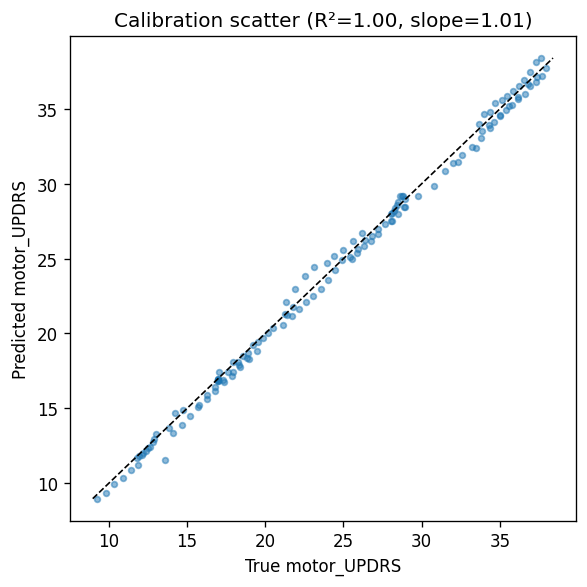

In [49]:
# 1) True vs Pred scatter
plt.figure(figsize=(5,5))
plt.scatter(y_test_abs, y_test_pred_abs, s=12, alpha=0.5)
lims = [min(y_test_abs.min(), y_test_pred_abs.min()), max(y_test_abs.max(), y_test_pred_abs.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True motor_UPDRS"); plt.ylabel("Predicted motor_UPDRS")
plt.title(f"Calibration scatter (R²={r2:.2f}, slope={slope:.2f})")
plt.tight_layout(); plt.show()

**Explanation of Calibration Scatter: True vs. Predicted motor_UPDRS**

*This figure assesses calibration and overall fidelity of the model on the absolute clinical scale. Each point is a test case with its true motor_UPDRS on the x-axis and the model’s predicted motor_UPDRS on the y-axis. The dashed 45° line represents perfect calibration; points on this line are predicted exactly, points above are overestimates, and points below are underestimates. The reported R² quantifies how much variance in the true scores is explained by the predictions, while the regression slope (shown in the title) indicates scaling: a slope near 1.0 with a small intercept suggests the model preserves the scale of UPDRS without systematic compression or expansion. Visual inspection should look for uniform scatter around the diagonal (good calibration), systematic curvature (non-linear bias), or a funnel shape (heteroscedastic errors that grow with severity).*

**Bland–Altman Plot**

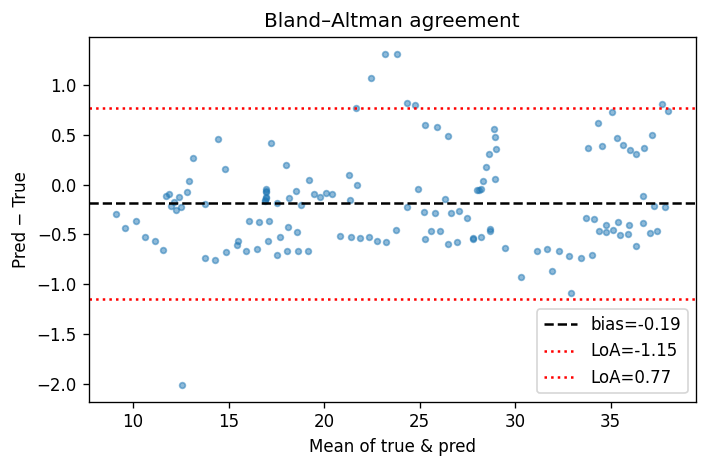

In [50]:
# 2) Bland–Altman plot
plt.figure(figsize=(6,4))
plt.scatter(mean_pair, diff, s=12, alpha=0.5)
plt.axhline(bias, color='k', linestyle='--', label=f"bias={bias:.2f}")
plt.axhline(loa[0], color='r', linestyle=':', label=f"LoA={loa[0]:.2f}")
plt.axhline(loa[1], color='r', linestyle=':', label=f"LoA={loa[1]:.2f}")
plt.xlabel("Mean of true & pred"); plt.ylabel("Pred − True")
plt.title("Bland–Altman agreement")
plt.legend(); plt.tight_layout(); plt.show()

**Explanation of Bland–Altman Agreement: Prediction Error vs. Mean Severity**

*This plot examines agreement and bias across the severity range by charting the prediction error (Pred − True) against the mean of the predicted and true UPDRS for each test case. The dashed horizontal line shows the average bias; values close to zero indicate no systematic over- or under-estimation. The dotted lines mark the 95% limits of agreement (mean bias ± 1.96×SD of the errors), providing an expected error band in UPDRS points. A well-behaved model will have most points within these limits with no visible trend of errors growing or shrinking as severity increases; any slope in the cloud suggests proportional bias. Interpreting the width of the limits relative to clinically meaningful change thresholds helps judge practical utility—for example, if the error band is narrower than a 3-point change on UPDRS Part III, the model’s variability is unlikely to mask meaningful progression.*

#Subgroup Performance by Sex and Age

Fairness and robustness are explored by slicing absolute errors by sex and age quartiles. Reporting subgroup MAEs for both the model and the naïve baseline reveals whether accuracy is consistent across demographic strata. When counts are small, results are interpreted cautiously, but consistent performance across subgroups increases confidence that the model’s behavior is broadly applicable.

In [42]:
# Subgroup MAE by subject, sex, and age
# Build a small subject-level demographic table from the original df
demo = df.groupby('subject#')[['age','sex']].agg(
    lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]
)

test_subjects = groups_all[test_idx]
sg = (pd.DataFrame({
        "subject": test_subjects,
        "err_model": abs_err_model,
        "err_naive": abs_err_naive
     })
     .merge(demo, left_on="subject", right_index=True, how="left"))

# Make sex human-readable (assuming 0/1 encoding)
sex_map = {0: "male", 1: "female"}
if set(sg['sex'].dropna().unique()).issubset({0,1}):
    sg['sex'] = sg['sex'].map(sex_map).astype('category')

print("\nMAE by sex:")
display(sg.groupby('sex', observed=True)[['err_model','err_naive']].mean())

# Age quartiles; create categorical bins and group with observed=True
sg['age_bin'] = pd.qcut(sg['age'], 4, duplicates='drop')

# To ensure no empty categories show up:
sg['age_bin'] = sg['age_bin'].cat.remove_unused_categories()

print("\nMAE by age quartile:")
display(sg.groupby('age_bin', observed=True)[['err_model','err_naive']].mean())


MAE by sex:


,err_model,err_naive
sex,,
female,0.571511,0.548276
male,0.331081,0.339022



MAE by age quartile:


,err_model,err_naive
age_bin,,
"(55.999, 57.0]",0.428309,0.420908
"(57.0, 58.0]",0.465750,0.472264
"(58.0, 68.0]",0.416138,0.405391


#**MODEL SUMMARY**
'updrs_lstmcnn' is a visit-level progression model that predicts the change in motor_UPDRS (ΔUPDRS) between successive clinic visits from short histories of voice. Inputs are the 16 standard acoustic features plus engineered first-order deltas and 3-visit rolling means, all z-scored within subject to remove personal baselines. A compact hybrid neural network—bidirectional GRU for temporal context and 1D CNN for local patterns—maps a sequence of visits to ΔUPDRS; the next absolute severity is reconstructed as last rating + predicted change. Hyperparameters (sequence length, L2) are selected with grouped cross-validation by subject, and the final model is trained on train+val and evaluated on held-out patients. Training uses Adam + Huber loss with early stopping and LR scheduling. Performance is benchmarked against a naïve last-value and a Ridge baseline and is further analyzed with calibration, Bland–Altman agreement, directional accuracy, and subgroup MAE. The result is a lean, stable pipeline that focuses on progression tracking rather than one-off scoring.

#**CONCLUSION**

The deployed screening classifier (Notebook 1 of 2) reliably extracts the 16 standard acoustic features from raw speech, proving the front end is production-ready. Building on that, this severity progression prediction model 'updrs_lstmcnn' predicts ΔUPDRS from short histories of voice and reconstructs the next absolute motor_UPDRS by adding the predicted change to the last known rating. On held-out subjects, absolute error is comparable to a strong “last-value” baseline and better than a Ridge model; ΔUPDRS error is sub-point on average, with reasonable calibration for tracking stability versus movement between visits.

While this progression model is not being deployed yet, it demonstrates a practical path to at-home severity monitoring that can complement clinic visits by highlighting meaningful trends. Next steps include enlarging and diversifying longitudinal data, expanding feature sets, and periodic re-anchoring to clinician ratings. This is a solid step toward remote, voice-based follow-up that supports ongoing care without replacing clinical judgment.